# Introduction to Data Science
## Assignment No.5
#### Kasra Ghorbani (810101489)
#### Mohammad Mahdi Samadi (810101465)

In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

## Getting familiar with the Dataset

In [129]:
df = pd.read_csv("./football.csv")
print(f"Dataset size: {len(df)}")
display(df.info())
display(df.head())

Dataset size: 8925
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8925 entries, 0 to 8924
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   matchId                8925 non-null   object 
 1   playerId               8925 non-null   object 
 2   playType               8925 non-null   object 
 3   bodyPart               8925 non-null   object 
 4   x                      8925 non-null   float64
 5   y                      8925 non-null   float64
 6   interveningOpponents   8925 non-null   int64  
 7   interveningTeammates   8925 non-null   int64  
 8   interferenceOnShooter  8891 non-null   object 
 9   minute                 8925 non-null   int64  
 10  second                 8925 non-null   int64  
 11  outcome                8891 non-null   object 
dtypes: float64(2), int64(4), object(6)
memory usage: 836.8+ KB


None

,matchId,playerId,playType,bodyPart,x,y,interveningOpponents,interveningTeammates,interferenceOnShooter,minute,second,outcome
0,m_91,p_103,open play,right foot,13.47,-11.22,1,0,medium,70,9,goal
1,m_17,p_16,open play,left foot,9.48,14.22,3,0,medium,55,4,saved by keeper
2,m_111,p_88,free kick,left foot,29.43,-1.25,6,2,low,86,31,saved by keeper
3,m_142,p_87,open play,right foot,26.93,1.00,4,1,medium,77,2,missed chance
4,m_117,p_9,open play,right foot,10.72,5.24,2,0,medium,76,46,goal


In [130]:
for col in ["playType", "outcome", "bodyPart"]:
    print(f"\n{col} values: ")
    print(*df[col].unique(), sep=", ")


playType values: 
open play, free kick, penalty, olimpico

outcome values: 
goal, saved by keeper, missed chance, blocked shot, hit the post, nan

bodyPart values: 
right foot, left foot, head, other


In [131]:
df[df["playType"] == "olimpico"]

,matchId,playerId,playType,bodyPart,x,y,interveningOpponents,interveningTeammates,interferenceOnShooter,minute,second,outcome
802,m_2,p_132,olimpico,left foot,0.25,-33.92,2,0,low,76,49,hit the post
1720,m_214,p_109,olimpico,right foot,0.00,33.92,3,0,low,61,30,hit the post
2160,m_131,p_20,olimpico,right foot,0.25,33.92,4,2,low,33,22,goal
5357,m_100,p_65,olimpico,head,7.98,1.25,4,0,high,27,28,goal


Seems that *olimpico* shots are taken from a very tight angle and probably directly from the corner kick. Since they're very rare i don't think changing their labels whould hurt much. Since they're similar to free kicks we'll label them as it.

## Fill Missing Values
There are several methods to handle missing values. For example replacing them with mean/median/mode of that column, predicting them based on the values of a related column or as an more advanced way we could use classification algorithms like random forest, decision tree, etc to estimate the missing values. Considering the small proportion of missing data, a simple approach like mode should work well. Given the large dataset provided to us, We could also exclude these data points and not lose significant information. 

In [132]:
display(df["interferenceOnShooter"].value_counts())
display(df["outcome"].value_counts())

interferenceOnShooter
medium    4186
low       3315
high      1390
Name: count, dtype: int64

outcome
missed chance      3470
saved by keeper    2395
blocked shot       1771
goal               1081
hit the post        174
Name: count, dtype: int64

In [133]:
df["interferenceOnShooter"]  = df["interferenceOnShooter"].fillna(df["interferenceOnShooter"].mode()[0])
df["outcome"] = df["outcome"].fillna(df["outcome"].mode()[0])

## Cleaning Dataset

In [134]:
def clean_IDs(df):
    for col in ["playerId", "matchId"]:
        df[col] = df[col].apply(lambda x: int(x.split("_")[1]))
    return df

df = clean_IDs(df=df)

non_numeric_cols = df.select_dtypes(include=["object", "bool"]).columns
def create_hash_dicts(df, categorical_columns):
    stoi = dict()
    for col in categorical_columns:
        unique_values = list(df[col].unique())
        for i in range(len(unique_values)):
            stoi[unique_values[i]] = i
    return stoi

stoi = create_hash_dicts(df, non_numeric_cols)

def label_columns(df, non_numeric_cols):
    for col in non_numeric_cols:
        df[col] = df[col].apply(lambda x: stoi[x])

label_columns(df, non_numeric_cols)

## Similar Features
There might be connection between some features and it can be found using several methods. Extracting new and more useful features like distance and angle allows us to throw some old features like x and y away. In other words they're not usefull anymore and keeping them isn't computationally efficient.

In [135]:
def find_possible_correlations(df, correlation_coefficient_threshold):
    df_corr = df.corr()
    is_correlated_columns = False
    for c1 in df_corr.columns:
        for c2 in df_corr.index:
            if c1 == c2:
                break
            if (abs(df_corr[c1][c2]) > correlation_coefficient_threshold):            
                print(f"There is a strong correlation between {c1} and {c2}")
                is_correlated_columns = True
    if not is_correlated_columns:
        print("Didn't found any two correlated column")

target = "outcome"
def calc_mutual_info(df, target):
    feat_selector = mutual_info_classif(df.drop(target, axis=1), df[target])
    feat_importance_df = pd.DataFrame({'Features': df.columns.drop(target), 'Importance': feat_selector})
    feat_importance_df = feat_importance_df.sort_values('Importance', ascending=False).reset_index(drop=True)
    return feat_importance_df

## Preprocessing

For the evaluating part, there are several models such as *logistic regression*, *decision tree*, *support vector machines*, *random forests*, *gaussian naive bayes*, *k-nearest neighbors*, *neural networks*, etc. Here we used two of them.

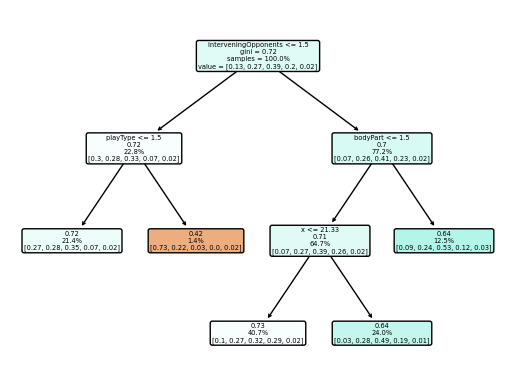

In [136]:
def count_unique(arr):
    unique_values = np.unique(arr)
    frequencies = np.bincount(arr)
    return dict(zip(unique_values, frequencies))

from sklearn.tree import plot_tree
def visualize_decision_tree(model):
    plot_tree(decision_tree=model, feature_names=model.feature_names_in_,
          label="root", filled=True, impurity=True, node_ids=False,
          proportion=True, rounded=True, precision=2)

models_name = ["K nearest", "Random Forest", "Decision Tree"]

evaluation_df = pd.DataFrame(columns=models_name)

def evaluate_outcomes(df, evaluation_df):
    X_train, X_test, y_train, y_test = train_test_split(df.drop(target, axis=1), df[target], test_size=0.5, random_state=17)
    KN_model = KNeighborsClassifier(n_neighbors=9).fit(X_train, y_train)
    RF_model = RandomForestClassifier(n_estimators=150, criterion="log_loss", max_depth=10, max_features=5, bootstrap=True).fit(X=X_train, y=y_train)
    DT_model = DecisionTreeClassifier(random_state=17, criterion="gini", max_depth=5, max_leaf_nodes=5).fit(X=X_train, y=y_train)
    
    
    evaluation_df.loc[len(evaluation_df.index)] = [accuracy_score(y_test, KN_model.predict(X_test)),
     accuracy_score(y_test, RF_model.predict(X_test)),
     accuracy_score(y_test, DT_model.predict(X_test))]
    
    visualize_decision_tree(DT_model)
    return evaluation_df
evaluation_df = evaluate_outcomes(df, evaluation_df)

In [137]:
find_possible_correlations(df=df, correlation_coefficient_threshold=0.7)
display(calc_mutual_info(df=df, target=target))

Didn't found any two correlated column


,Features,Importance
0,interveningOpponents,0.060880
1,x,0.039065
2,y,0.033515
3,interveningTeammates,0.027028
4,playType,0.021000
5,interferenceOnShooter,0.011221
6,bodyPart,0.010136
7,matchId,0.001886
8,second,0.001636
9,playerId,0.000000


In [138]:
print(df.corr()[target])

matchId                  0.019852
playerId                 0.015088
playType                -0.095422
bodyPart                -0.027139
x                        0.135572
y                       -0.011418
interveningOpponents     0.238100
interveningTeammates     0.118922
interferenceOnShooter    0.040865
minute                   0.009705
second                   0.006868
outcome                  1.000000
Name: outcome, dtype: float64


## Add, Extract, Improve and Remove Features
*Euclidian Distance:*

$$ \quad \text {dis = } \sqrt {x^2 + y^2} $$

*Angle (using the Law of Cosinos):*

$$
\quad a^2 = b^2 + c^2 - 2bc\cos{\theta} \\
\quad \cos(\theta) = \frac{b^2 + c^2 - a^2}{2bc} \\
\quad \theta = \cos^{-1}(\cos(\theta)) \\
\quad \theta^\circ = \theta \times \frac{180}{\pi} 
$$

*other Players Effect:* a newly extracted feature that measures the impact of nearby players (both opponents and teammates) on the probability of a shot going to the goal.

*Ball Position Rate:* It is extracted from the information we have about the position of the ball and measures how well the ball is positioned at the moment it is shot.

*outcome:* According to the assignment description, our task is to predict whether a shot results in a goalt. Converting the outcome column to a boolean variable will be helpful to reach this purpose.

In [139]:
def calc_dis(x, y):
    return np.sqrt(x ** 2 + y ** 2)

def calc_angle(x, y):
    a = 7.32; b = calc_dis(x, y + 3.66); c = calc_dis(x, y - 3.66)
    return np.arccos((b**2 + c**2 - a**2) / (2*b*c))

In [140]:
def add_feature(df):
    df["distance"] = df.apply(lambda p: calc_dis(p["x"], p["y"]), axis=1)
    df["angle"] = df.apply(lambda p: calc_angle(p["x"], p["y"]), axis=1)
    df["otherPlayersEffect"] = df.apply(lambda x:
                        int(x["interferenceOnShooter"] == stoi["low"]) * 4 +
                        int(x["interferenceOnShooter"] == stoi["medium"]) * 2 +
                        int(x["interveningOpponents"]) < 3 +
                        int(x["interveningTeammates"] > 0)
                        , axis=1)
    df["ballPositionRate"] = df.apply( lambda x:
                        int((x['x'] < 16.5) and (abs(x['y']) < 16.5 + 3.66)) +
                        int(x["angle"] > 50) +
                        int(x["playType"] == stoi["penalty"])
                        , axis=1)
    df["playType"] = df["playType"].apply(lambda x: stoi["free kick"] if x == stoi["olimpico"] else x)
    df["outcome"] = df["outcome"].apply(lambda x: True if x == stoi["goal"] else False)
    return df



There is a strong correlation between distance and x
There is a strong correlation between ballPositionRate and x
There is a strong correlation between ballPositionRate and distance


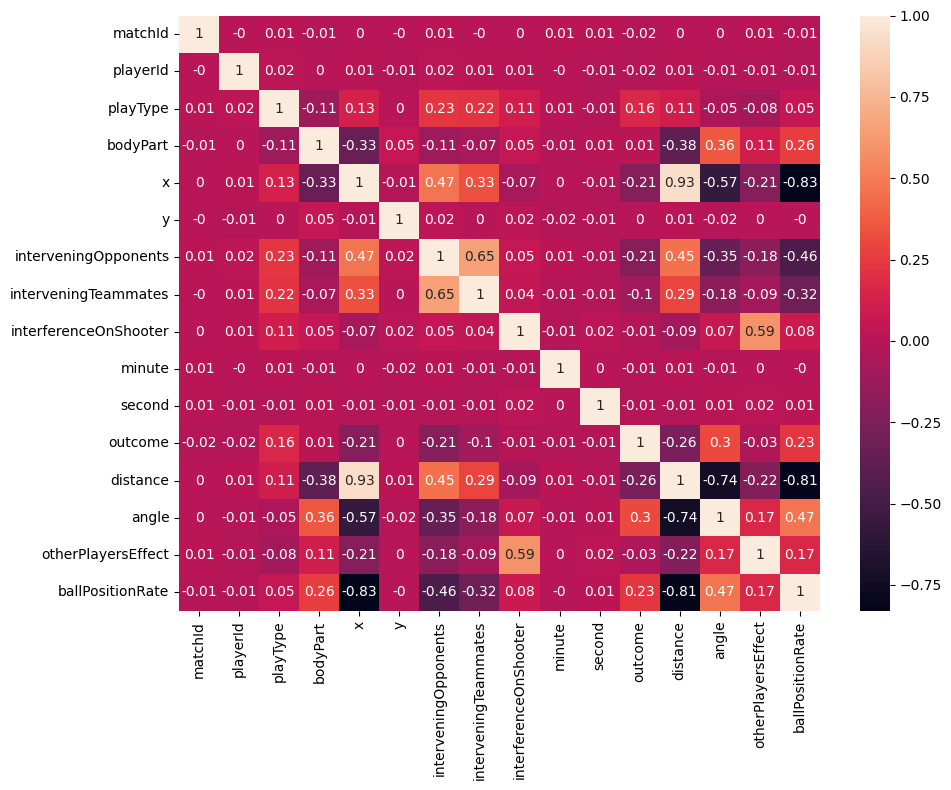

In [141]:
def generate_heatmap_of_correlations(df):
    plt.figure(figsize=(10,8))
    sns.heatmap(round(df.corr(), 2), annot=True)
    plt.tight_layout()
    plt.show()

df = add_feature(df=df)
find_possible_correlations(df=df, correlation_coefficient_threshold=0.8)
generate_heatmap_of_correlations(df=df)

#### Why is there a strong correlation between *distance* and *x* and not *y*?
In football games, most shots are taken from a wide angle. Players don't usually take the risk of trying tight angle shots. This is why the x values are significantly greater than y values. As a result in the Euclidean distance formula, the x-coordinate will have a more influence on the calculation than the y-coordinate. Additionally, in the angle feature calculation, the y-coordinate is more critical.

In [142]:
df[["x", "y", "distance"]].describe()

,x,y,distance
count,8925.000000,8925.000000,8925.000000
mean,14.564631,0.364408,17.145509
std,7.841865,8.999063,7.794973
min,0.000000,-33.920000,0.353553
25%,8.480000,-5.740000,10.970000
50%,12.470000,0.500000,15.871950
75%,20.950000,6.730000,23.629932
max,70.820000,33.920000,71.783221


In [143]:
df = add_feature(df=df)
df = df.drop(["second", "minute", "matchId", "playerId", "y", "otherPlayersEffect"], axis=1)
find_possible_correlations(df=df, correlation_coefficient_threshold=0.8)
display(calc_mutual_info(df=df, target=target))

There is a strong correlation between distance and x
There is a strong correlation between ballPositionRate and x
There is a strong correlation between ballPositionRate and distance


,Features,Importance
0,angle,0.056322
1,distance,0.053004
2,x,0.040596
3,interveningOpponents,0.040474
4,ballPositionRate,0.038194
5,interveningTeammates,0.012023
6,playType,0.011910
7,interferenceOnShooter,0.008930
8,bodyPart,0.002221


In [144]:
df.corr()[target]

playType                -0.161828
bodyPart                -0.014100
x                        0.213988
interveningOpponents     0.211525
interveningTeammates     0.100845
interferenceOnShooter    0.006725
outcome                  1.000000
distance                 0.257896
angle                   -0.304126
ballPositionRate        -0.226786
Name: outcome, dtype: float64

We used three different classification models to evaluate the results.

,K nearest,Random Forest,Decision Tree
before,0.309657,0.421017,0.405333
after,0.884831,0.893345,0.891777


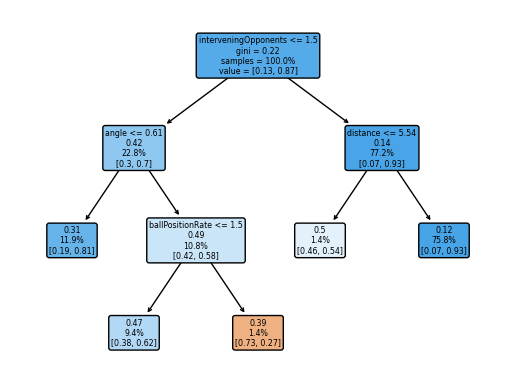

In [145]:
evaluation_df = evaluate_outcomes(df, evaluation_df)
evaluation_df.index = ["before", "after"]
evaluation_df

#### Why didn't we use regression to predict whether a shot results in a goal?
Regression models are used for predicting continuous numerical values rather than categorical outcomes.
#### verifying the accuracy of the given formula used to calculate the shot angle in the preprocessing section.
Actually we didn't use the given formula. Instead we used the law of cosinos to calculate the angle.